In [141]:
import copy
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster, 
    RecursiveRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss, MASE, mase_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

# 1 Load data

## 1.1 Load exchange rates data (ECB)

In [3]:
from datetime import date
import io
import requests
import zipfile

EXCHANGE_RATES_URL = 'http://www.ecb.int/stats/eurofxref/eurofxref-hist.zip'

def request_exchange_rates():
    r = requests.get(url=EXCHANGE_RATES_URL, stream=True)
    zip_file = zipfile.ZipFile(io.BytesIO(r.content))
    df = pd.read_csv(zip_file.open(zip_file.namelist()[0]))
    return df


def get_currency_exchange_rate(currencies: list):
    exchange_rates = request_exchange_rates()

    exchange_rates['Date'] = pd.to_datetime(exchange_rates['Date'], infer_datetime_format=True)
    exchange_rates['Day'] = exchange_rates['Date'].dt.day
    exchange_rates['Month'] = exchange_rates['Date'].dt.month
    exchange_rates['Year'] = exchange_rates['Date'].dt.year

    exchange_rates.sort_values(by=['Year', 'Month', 'Day'], inplace=True)
    exchange_rates.set_index('Date', inplace=True)
    
    indexed_df = pd.DataFrame()
    indexed_df['Date'] = pd.date_range(exchange_rates.index[0], exchange_rates.index[-1], freq='1H')
    indexed_df.set_index('Date')
    
    exchange_rates = pd.merge(exchange_rates, indexed_df, how='left', left_index=True,  right_index=True)
    exchange_rates.fillna(method='ffill', inplace=True)
    exchange_rates.fillna(method='bfill', inplace=True)

    exchange_rates['EUR'] = 1
    assert set(currencies).issubset(set(exchange_rates.columns)), 'Unknown currency'
    keep_columns = list(currencies)
    exchange_rates = exchange_rates[keep_columns]
    return exchange_rates
    
    
exchange_rates = get_currency_exchange_rate(currencies=['PLN'])
exchange_rates.head()

,PLN
Date,
1999-01-04 00:00:00,4.0712
1999-01-05 00:00:00,4.0245
1999-01-06 00:00:00,4.0065
1999-01-07 00:00:00,4.0165
1999-01-08 00:00:00,4.0363


In [4]:
exchange_rates.index = pd.to_datetime(exchange_rates.index)
exchange_rates = exchange_rates.resample('H').ffill()

exchange_rates.head()

,PLN
Date,
1999-01-04 00:00:00,4.0712
1999-01-04 01:00:00,4.0712
1999-01-04 02:00:00,4.0712
1999-01-04 03:00:00,4.0712
1999-01-04 04:00:00,4.0712


## 1.2 Load external predictions

In [5]:
external_predictions = pd.read_csv("historical_forecasts.csv", sep=";")

external_predictions.head()

,delivery_date,forecast_n-1_9:00
0,2019-09-02 00:00:00,"52,89"
1,2019-09-02 01:00:00,"51,43"
2,2019-09-02 02:00:00,"50,57"
3,2019-09-02 03:00:00,"50,37"
4,2019-09-02 04:00:00,"50,28"


In [6]:
external_predictions = external_predictions.rename(columns={'delivery_date': 'date', 'forecast_n-1_9:00': 'forecast'})
external_predictions['date'] = pd.to_datetime(external_predictions['date'])
external_predictions['forecast'] = external_predictions['forecast'].str.replace(',', '.').astype('float64')
external_predictions = external_predictions.set_index('date').sort_index()

external_predictions.head()

,forecast
date,
2019-09-02 00:00:00,52.89
2019-09-02 01:00:00,51.43
2019-09-02 02:00:00,50.57
2019-09-02 03:00:00,50.37
2019-09-02 04:00:00,50.28


In [7]:
external_predictions = external_predictions.merge(exchange_rates, how='left', left_index=True, right_index=True)

external_predictions.head()

,forecast,PLN
2019-09-02 00:00:00,52.89,4.3691
2019-09-02 01:00:00,51.43,4.3691
2019-09-02 02:00:00,50.57,4.3691
2019-09-02 03:00:00,50.37,4.3691
2019-09-02 04:00:00,50.28,4.3691


In [8]:
external_predictions['forecast_PLN'] = external_predictions['forecast'] * external_predictions['PLN']
external_predictions = external_predictions.drop(['forecast', 'PLN'], axis=1)

external_predictions.head()

,forecast_PLN
2019-09-02 00:00:00,231.081699
2019-09-02 01:00:00,224.702813
2019-09-02 02:00:00,220.945387
2019-09-02 03:00:00,220.071567
2019-09-02 04:00:00,219.678348


In [9]:
external_predictions.tail(30)

,forecast_PLN
2021-03-31 18:00:00,307.789944
2021-03-31 19:00:00,319.742500
2021-03-31 20:00:00,313.045348
2021-03-31 21:00:00,307.417880
2021-03-31 22:00:00,297.837232
2021-03-31 23:00:00,274.211168
2021-04-01 00:00:00,239.201910
2021-04-01 01:00:00,233.486874
2021-04-01 02:00:00,232.288560
2021-04-01 03:00:00,231.320691


In [10]:
external_predictions = external_predictions[~external_predictions['forecast_PLN'].isnull()]
external_predictions = external_predictions.iloc[~external_predictions.index.duplicated(keep="first")]

## 1.3 Load original data - realised prices

In [11]:
raw_data = pd.read_csv('prices.csv')
raw_data.head()

,delivery_start_utc,delivery_end_utc,price
0,21.03.2021 22:00:00,21.03.2021 23:00:00,244.29
1,21.03.2021 21:00:00,21.03.2021 22:00:00,260.00
2,21.03.2021 20:00:00,21.03.2021 21:00:00,265.00
3,21.03.2021 19:00:00,21.03.2021 20:00:00,286.10
4,21.03.2021 18:00:00,21.03.2021 19:00:00,295.79


In [12]:
dates = pd.to_datetime(raw_data['delivery_start_utc'], format='%d.%m.%Y %H:%M:%S')
data = raw_data[['price']]
data.index = dates
data = data.sort_index()
data.index.freq = 'H'

data.head()

,price
delivery_start_utc,
2010-01-01 00:00:00,129.30
2010-01-01 01:00:00,110.17
2010-01-01 02:00:00,104.46
2010-01-01 03:00:00,105.00
2010-01-01 04:00:00,105.01


In [13]:
index_copy = data.index
data = data.merge(external_predictions, how='left', right_index=True, left_index=True)
data.index = index_copy

data.head()

,price,forecast_PLN
delivery_start_utc,,
2010-01-01 00:00:00,129.30,NaN
2010-01-01 01:00:00,110.17,NaN
2010-01-01 02:00:00,104.46,NaN
2010-01-01 03:00:00,105.00,NaN
2010-01-01 04:00:00,105.01,NaN


In [14]:
data.tail()

,price,forecast_PLN
delivery_start_utc,,
2021-03-21 18:00:00,295.79,243.2430
2021-03-21 19:00:00,286.10,266.2044
2021-03-21 20:00:00,265.00,264.1716
2021-03-21 21:00:00,260.00,247.3548
2021-03-21 22:00:00,244.29,237.2832


## 1.4 Load data - features

In [69]:
import pickle5 as pickle

extractor_features = [
    'RealUnitsOutagesExtractor',
    'CO2PriceExtractor',
    'ForecastsExtractor',
    'RealBasicDataExtractor',
    'RealExchangesExtractor',
    'RealResGenerationExtractor',
    'RealUnitsGenerationExtractor',
]

features = dict()
for extractor_feature in extractor_features:
    file = open(f'data/{extractor_feature}', 'rb')
    features[extractor_feature] = pickle.load(file)
    file.close()

In [70]:
features

{'RealUnitsOutagesExtractor':          Data Godzina   Elektrownia    Kod JW Wielkość ubytku elektrownianego  \
 0    20170101       1        Adamów  ADM 1-01                          40,000   
 1    20170101       1        Adamów  ADM 2-05                          40,000   
 2    20170101       1     Bełchatów  BEL 2-01                         370,000   
 3    20170101       1  EC Włocławek  WLC 2-01                         485,000   
 4    20170101       1     Karolin 2  KAR 1-03                          10,500   
 ..        ...     ...           ...       ...                             ...   
 505  20201231      24         Turów  TUR 2-03                         235,000   
 506  20201231      24         Turów  TUR 2-04                         101,000   
 507  20201231      24         Turów  TUR 2-05                         101,000   
 508  20201231      24         Turów  TUR 2-06                         261,000   
 509  20201231      24         Turów  TUR 4-11                       

# Explonatory data analysis

In [113]:
def assign_date_features(df):
    df_copy = df.copy()
    df_copy = df_copy.assign(
        year=df_copy.index.year,
        month=df_copy.index.month,
        mday=df_copy.index.day,
        wday=df_copy.index.weekday,
        hour=df_copy.index.hour,
    )
    return df_copy


### EDA - CO2PriceExtractor

In [93]:
feature = features['CO2PriceExtractor']

In [94]:
feature

,Data,RCCO2 [zł/Mg CO2],RCCO2 [EUR/Mg CO2]
0,2017-01-01,28.48,6.44
0,2017-01-02,27.08,6.13
0,2017-01-03,23.91,5.43
0,2017-01-04,25.05,5.71
0,2017-01-05,23.14,5.29
...,...,...,...
0,2020-12-27,143.76,31.89
0,2020-12-28,149.83,33.39
0,2020-12-29,148.43,32.95
0,2020-12-30,145.47,32.13


In [112]:
for column in ['RCCO2 [zł/Mg CO2]', 'RCCO2 [EUR/Mg CO2]']:
    feature[column] = feature[column].str.replace(',',  '.').astype("float64")

AttributeError: Can only use .str accessor with string values!

In [101]:
feature['Data'] = pd.to_datetime(feature['Data'], format="%Y-%m-%d")
feature.set_index('Data', inplace=True)
feature

,RCCO2 [zł/Mg CO2],RCCO2 [EUR/Mg CO2]
Data,,
2017-01-01,28.48,6.44
2017-01-02,27.08,6.13
2017-01-03,23.91,5.43
2017-01-04,25.05,5.71
2017-01-05,23.14,5.29
...,...,...
2020-12-27,143.76,31.89
2020-12-28,149.83,33.39
2020-12-29,148.43,32.95


In [102]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1331 entries, 2017-01-01 to 2020-12-31
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RCCO2 [zł/Mg CO2]   1331 non-null   float64
 1   RCCO2 [EUR/Mg CO2]  1331 non-null   float64
dtypes: float64(2)
memory usage: 31.2 KB


In [103]:
feature.describe()

,RCCO2 [zł/Mg CO2],RCCO2 [EUR/Mg CO2]
count,1331.000000,1331.000000
mean,83.061946,19.130887
std,34.378754,7.774599
min,18.340000,4.350000
25%,55.515000,13.120000
50%,94.490000,21.510000
75%,109.895000,25.345000
max,150.580000,33.390000


In [116]:
feature.isnull().sum()

RCCO2 [zł/Mg CO2]     0
RCCO2 [EUR/Mg CO2]    0
dtype: int64

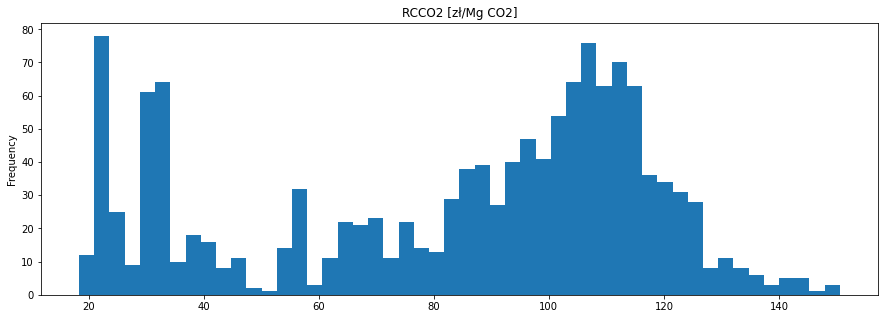

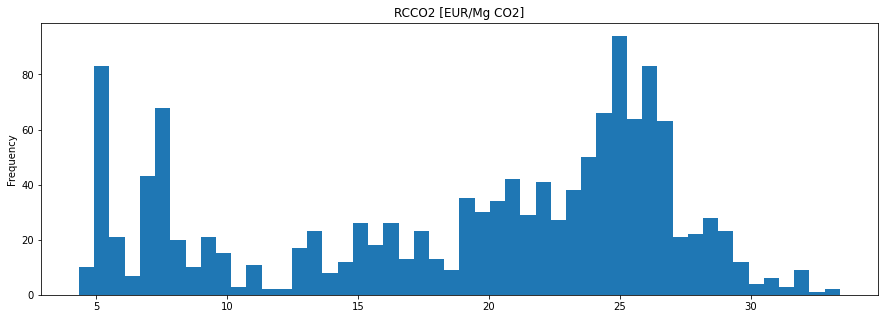

In [138]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

for column in feature:
    plt.figure(column)
    plt.title(column)
    if is_numeric_dtype(feature[column]):
        feature[column].plot(kind='hist', bins=50)
    elif is_string_dtype(feature[column]):
        feature[column].value_counts()[:10].plot(kind='bar')

In [139]:
feature_ext = assign_date_features(feature)
feature_ext

,RCCO2 [zł/Mg CO2],RCCO2 [EUR/Mg CO2],year,month,mday,wday,hour
Data,,,,,,,
2017-01-01,28.48,6.44,2017,1,1,6,0
2017-01-02,27.08,6.13,2017,1,2,0,0
2017-01-03,23.91,5.43,2017,1,3,1,0
2017-01-04,25.05,5.71,2017,1,4,2,0
2017-01-05,23.14,5.29,2017,1,5,3,0
...,...,...,...,...,...,...,...
2020-12-27,143.76,31.89,2020,12,27,6,0
2020-12-28,149.83,33.39,2020,12,28,0,0
2020-12-29,148.43,32.95,2020,12,29,1,0


In [140]:
years = feature_ext['year'].unique()

In [131]:
def plot_co2_histograms(col, bins=10):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    for ax, year in zip(axes.ravel(), years):
        ax.hist(feature_ext[feature_ext['year']==year][col], bins=bins)
        ax.grid()
        ax.set_title(f'{col} histogram for year {year}')
    plt.tight_layout()

<AxesSubplot:>

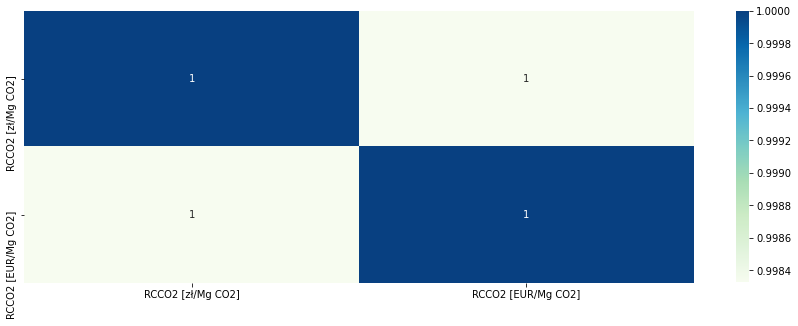

In [145]:
#TODO: add response here

correlation = feature.corr()
sns.heatmap(correlation, cmap='GnBu', annot=True)

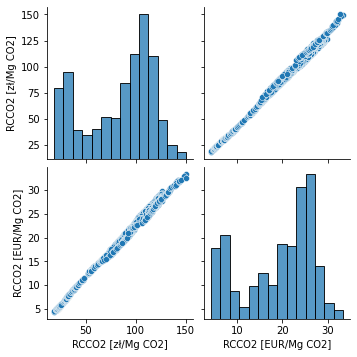

In [148]:
sns.pairplot(feature)

In [150]:
#TODO
sns.scatterplot(feature)

ValueError: If using all scalar values, you must pass an index

### EDA - response variable

In [15]:
y = data['price']

y.head()

delivery_start_utc
2010-01-01 00:00:00    129.30
2010-01-01 01:00:00    110.17
2010-01-01 02:00:00    104.46
2010-01-01 03:00:00    105.00
2010-01-01 04:00:00    105.01
Freq: H, Name: price, dtype: float64

In [16]:
y.tail()

delivery_start_utc
2021-03-21 18:00:00    295.79
2021-03-21 19:00:00    286.10
2021-03-21 20:00:00    265.00
2021-03-21 21:00:00    260.00
2021-03-21 22:00:00    244.29
Freq: H, Name: price, dtype: float64

In [17]:
len(y)

98351

In [18]:
y.describe()

count    98351.000000
mean       186.746688
std         62.415608
min         31.000000
25%        146.840000
50%        180.000000
75%        211.330000
max       1405.440000
Name: price, dtype: float64

In [19]:
sum(y.isnull())

0

<AxesSubplot:>

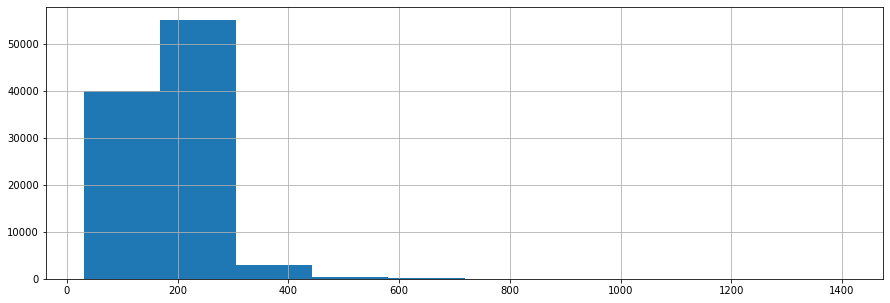

In [20]:
y.hist()

<AxesSubplot:>

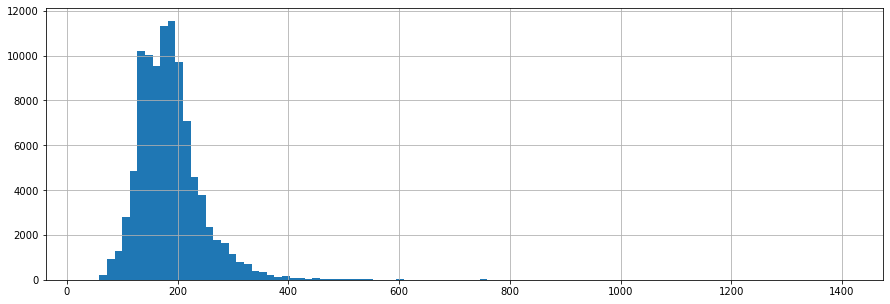

In [21]:
y.hist(bins=100)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

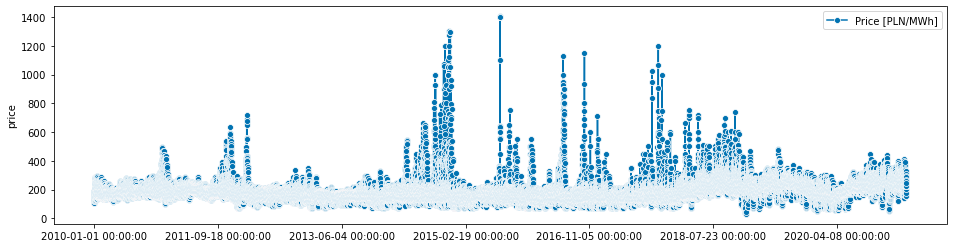

In [22]:
plot_series(y, labels=['Price [PLN/MWh]'])

In [23]:
y_ext = pd.DataFrame().assign(
    year=y.index.year,
    month=y.index.month,
    mday=y.index.day,
    wday=y.index.weekday,
    hour=y.index.hour,
    price=y.values
)

In [24]:
y_ext

,year,month,mday,wday,hour,price
0,2010,1,1,4,0,129.30
1,2010,1,1,4,1,110.17
2,2010,1,1,4,2,104.46
3,2010,1,1,4,3,105.00
4,2010,1,1,4,4,105.01
...,...,...,...,...,...,...
98346,2021,3,21,6,18,295.79
98347,2021,3,21,6,19,286.10
98348,2021,3,21,6,20,265.00
98349,2021,3,21,6,21,260.00


### Month/weekday aggregation

Text(0.5, 1.0, 'Day ahead price per wday')

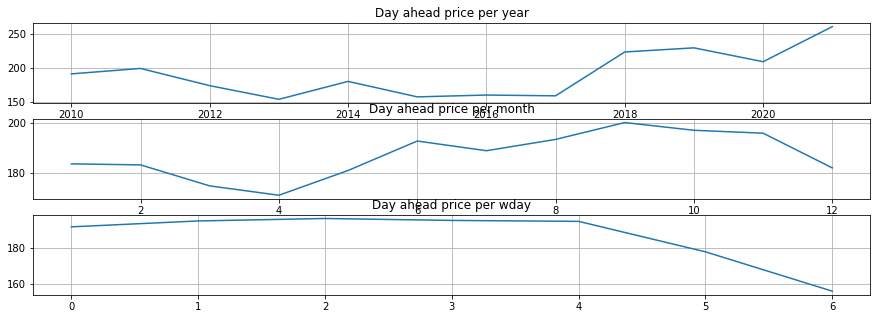

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=1)
axes[0].plot(y_ext.groupby('year').mean()['price'])
axes[0].grid()
axes[0].set_title('Day ahead price per year')

axes[1].plot(y_ext.groupby('month').mean()['price'])
axes[1].grid()
axes[1].set_title('Day ahead price per month')

axes[2].plot(y_ext.groupby('wday').mean()['price']) #Monday-0, Sunday-6
axes[2].grid()
axes[2].set_title('Day ahead price per wday')

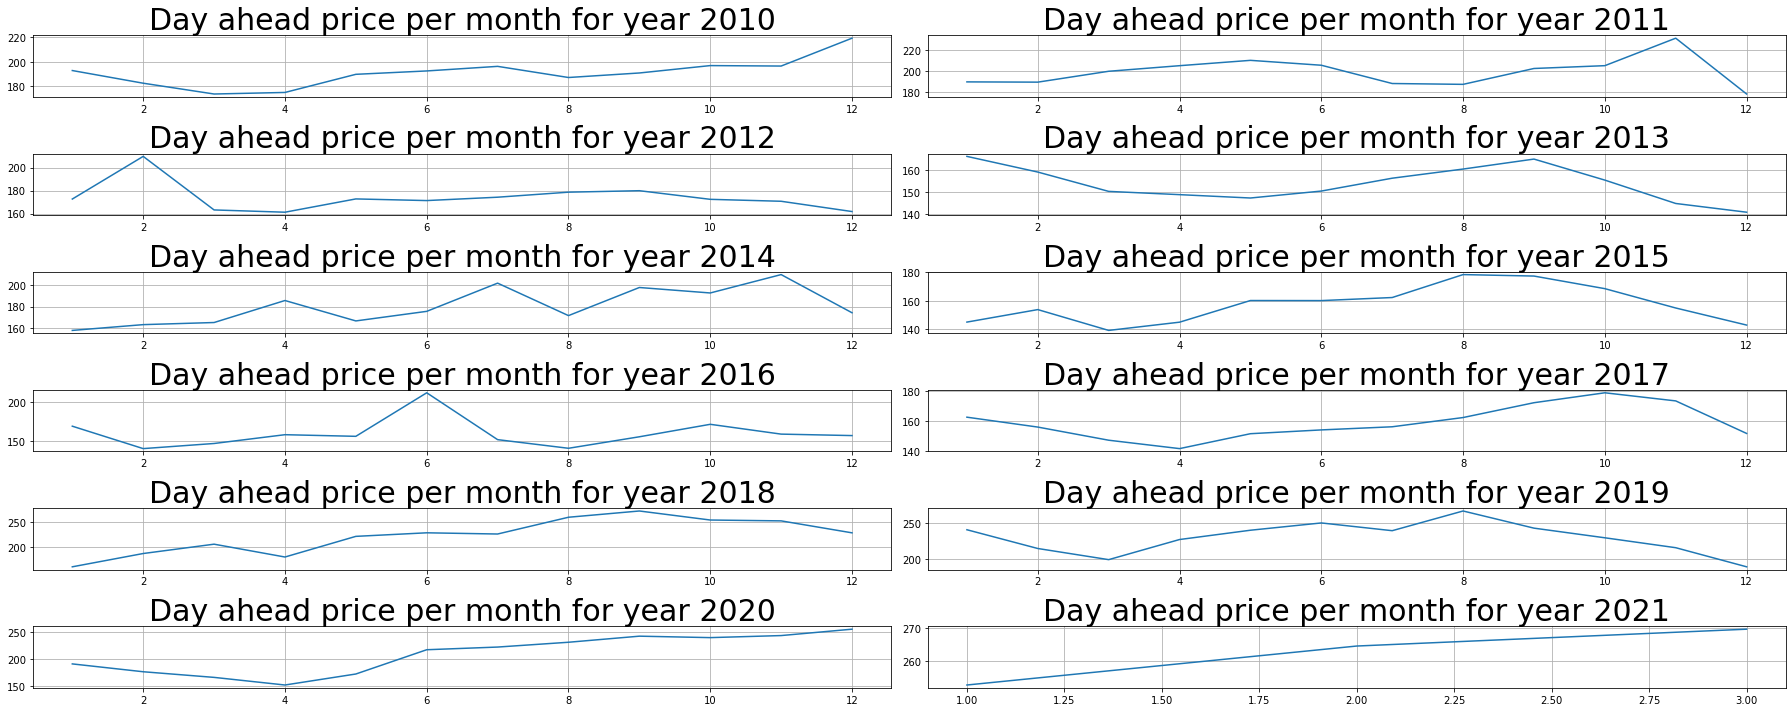

In [26]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(25,10))

years = y_ext['year'].unique()
for ax, year in zip(axes.ravel(), years):
    ax.plot(y_ext[y_ext['year'] == year].groupby('month').mean()['price'])
    ax.grid()
    ax.set_title(f'Day ahead price per month for year {year}', fontsize=30)
    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)
plt.tight_layout()


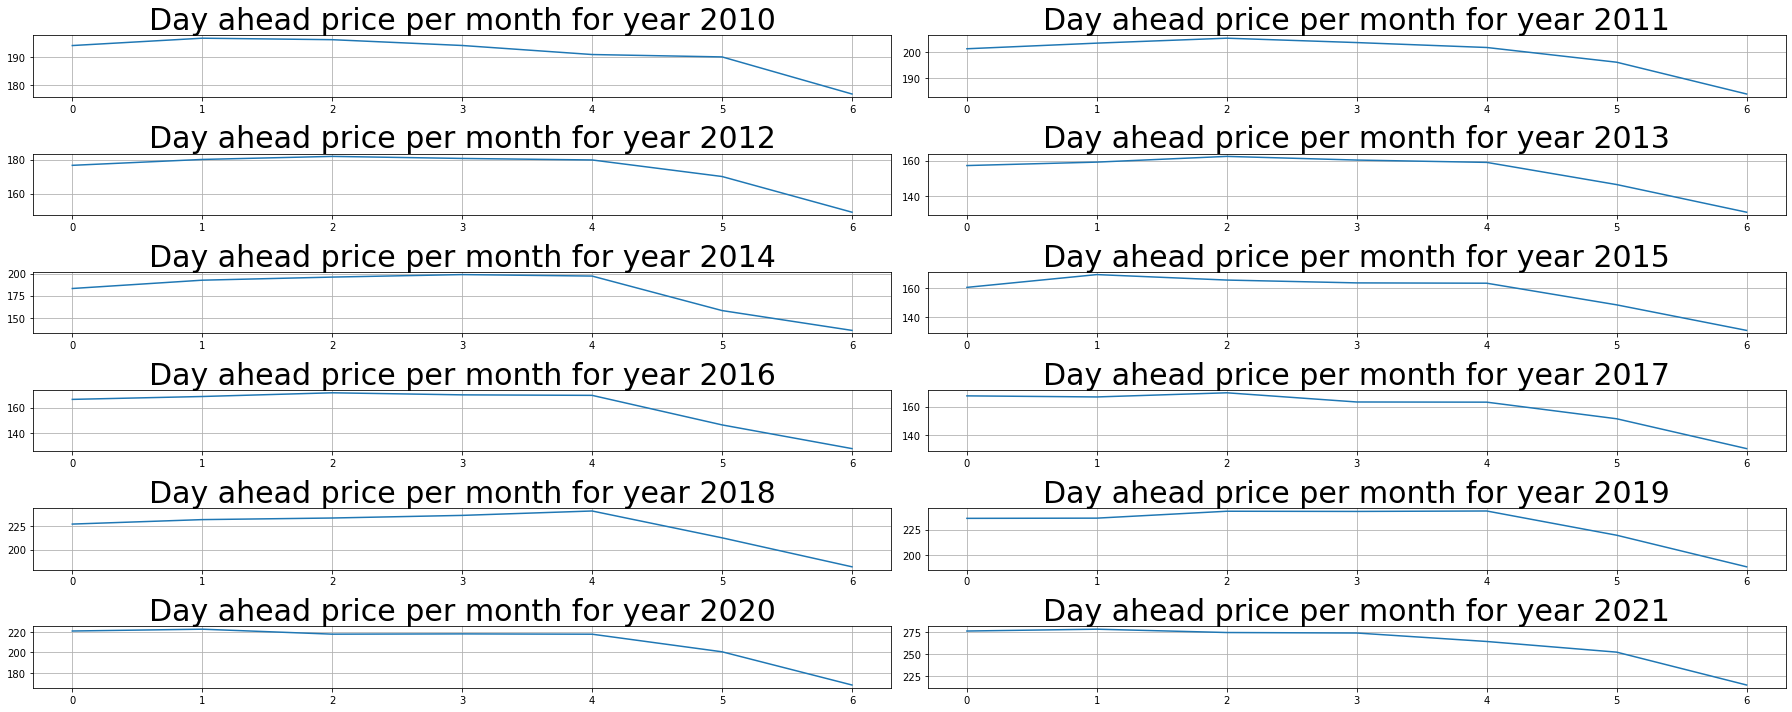

In [27]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(25,10))

years = y_ext['year'].unique()
for ax, year in zip(axes.ravel(), years):
    ax.plot(y_ext[y_ext['year'] == year].groupby('wday').mean()['price'])
    ax.grid()
    ax.set_title(f'Day ahead price per month for year {year}', fontsize=30)
    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)
plt.tight_layout()


Text(0.5, 1.0, 'Day ahead price per hour')

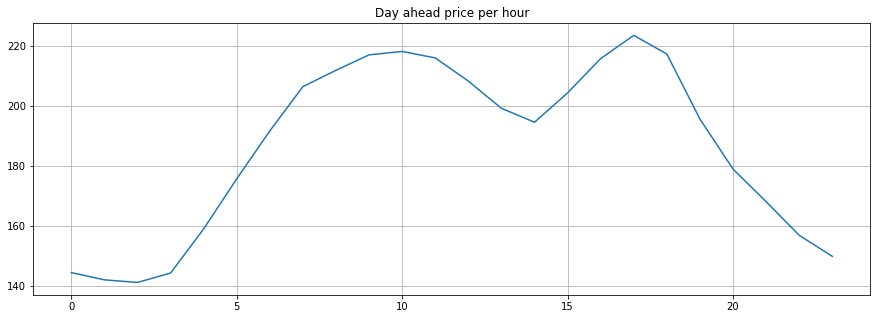

In [28]:
fig, ax = plt.subplots()
ax.plot(y_ext.groupby('hour').mean()['price'])
ax.grid()
ax.set_title('Day ahead price per hour')

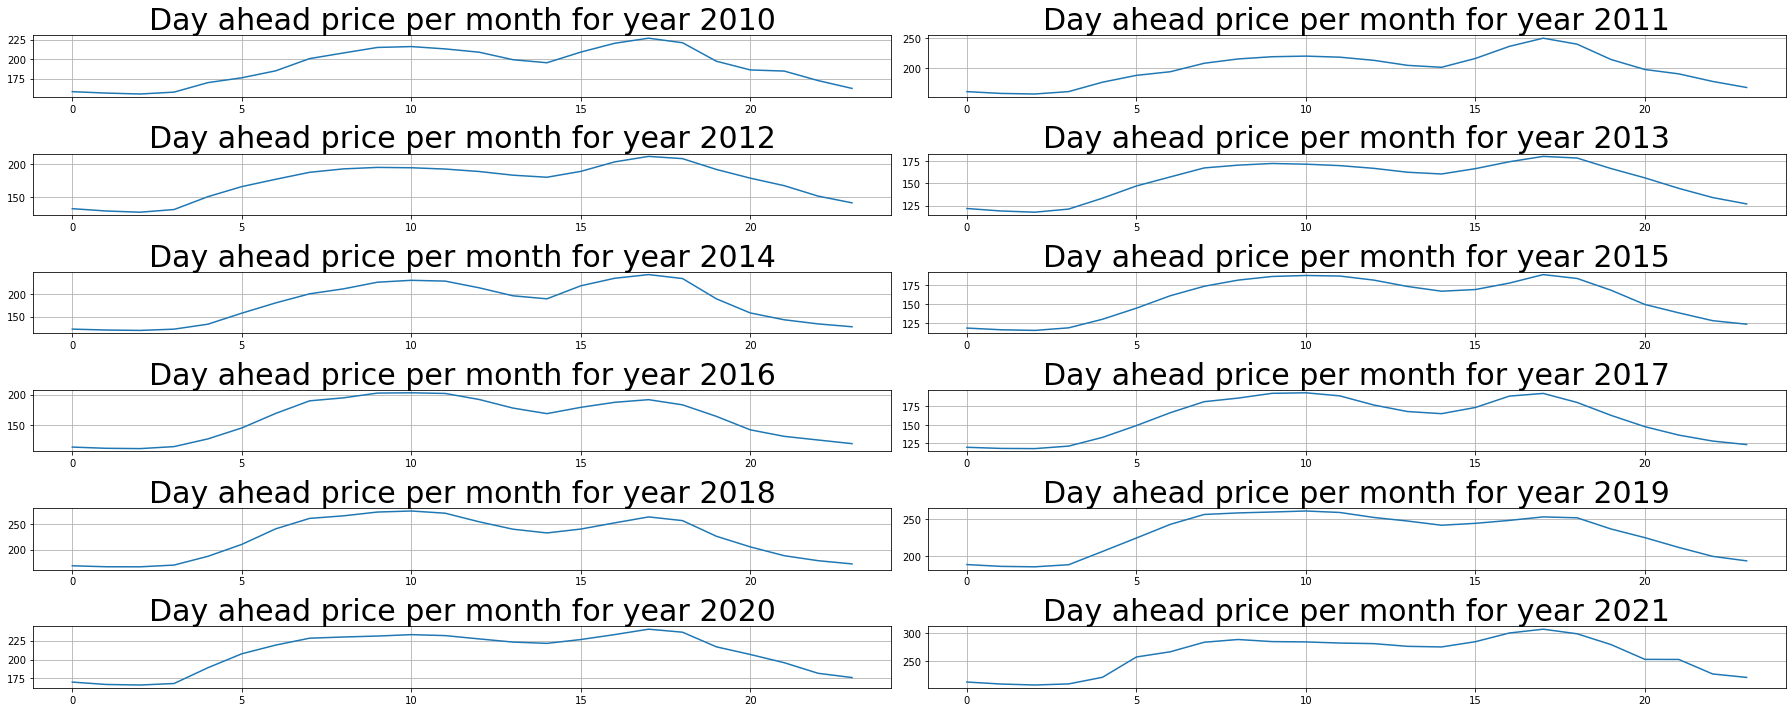

In [29]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(25,10))

years = y_ext['year'].unique()
for ax, year in zip(axes.ravel(), years):
    ax.plot(y_ext[y_ext['year'] == year].groupby('hour').mean()['price'])
    ax.grid()
    ax.set_title(f'Day ahead price per month for year {year}', fontsize=30)
    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)
plt.tight_layout()


# Train-test time series split

In [30]:
from datetime import datetime, timedelta

START_TRAIN_DATE = datetime(2020, 1, 1)
END_TRAIN_DATE = datetime(2020, 12, 31, 23, 0, 0)
START_TEST_DATE = END_TRAIN_DATE + timedelta(hours=1)
END_TEST_DATE = datetime(2021, 3, 20, 23, 0, 0)

y_train, y_test = y[START_TRAIN_DATE:END_TRAIN_DATE].copy(), y[START_TEST_DATE:END_TEST_DATE].copy()
print(f'y_train shape: {y_train.shape[0]}, y_test_shape: {y_test.shape[0]} ')

y_train shape: 8784, y_test_shape: 1896 


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

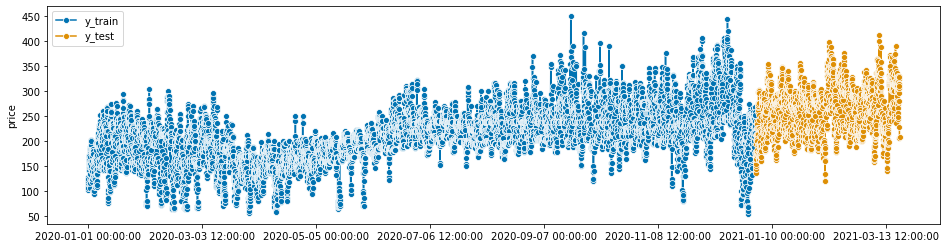

In [31]:
plot_series(y_train, y_test, labels=['y_train', 'y_test'])

In [32]:
y_ext_train = data['forecast_PLN'].loc[START_TRAIN_DATE:END_TRAIN_DATE]
y_ext_test = data['forecast_PLN'].loc[START_TEST_DATE:END_TEST_DATE]

In [33]:
data

,price,forecast_PLN
delivery_start_utc,,
2010-01-01 00:00:00,129.30,NaN
2010-01-01 01:00:00,110.17,NaN
2010-01-01 02:00:00,104.46,NaN
2010-01-01 03:00:00,105.00,NaN
2010-01-01 04:00:00,105.01,NaN
...,...,...
2021-03-21 18:00:00,295.79,243.2430
2021-03-21 19:00:00,286.10,266.2044
2021-03-21 20:00:00,265.00,264.1716


## Train/test subsample

In [34]:
START_TRAIN_SAMPLE_DATE = datetime(2020, 10, 31) 
END_TRAIN_SAMPLE_DATE = datetime(2020, 12, 31, 23, 0, 0)
START_TEST_SAMPLE_DATE = datetime(2021, 1, 1)
END_TEST_SAMPLE_DATE = datetime(2021, 1, 14, 23, 0, 0)
END_TEST_SAMPLE_DATE = datetime(2021, 1, 31, 23, 0, 0)

y_train_sample = y_train.loc[START_TRAIN_SAMPLE_DATE:END_TRAIN_SAMPLE_DATE]
y_test_sample = y_test.loc[START_TEST_SAMPLE_DATE:END_TEST_SAMPLE_DATE]

y_pred_train_sample = data['forecast_PLN'].loc[START_TRAIN_SAMPLE_DATE:END_TRAIN_SAMPLE_DATE]
y_pred_test_sample = data['forecast_PLN'].loc[START_TEST_SAMPLE_DATE:END_TEST_SAMPLE_DATE]

In [35]:
train_start_index = y_train_sample.index[0]
train_end_index = y_train_sample.index[-1]
test_start_index = y_test_sample.index[0]
test_end_index = y_test_sample.index[-1]

print(f'Train sample: from {train_start_index} to {train_end_index}')
print(f'Test sample: from {test_start_index} to {test_end_index}')

Train sample: from 2020-10-31 00:00:00 to 2020-12-31 23:00:00
Test sample: from 2021-01-01 00:00:00 to 2021-01-31 23:00:00


Naive forecaster RMSE: 88.68550698882873. External predictions RMSE: 25.32533193094695


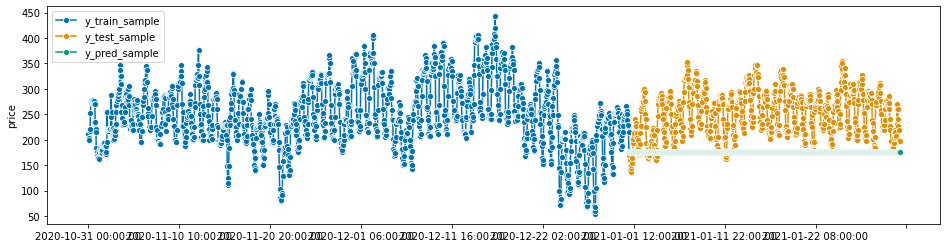

In [36]:
naive_forecaster = NaiveForecaster(strategy='last')
naive_forecaster.fit(y_train_sample)
fh_index = y_test_sample.index

fh = ForecastingHorizon(fh_index, is_relative=False)
y_pred_sample = naive_forecaster.predict(fh)
plot_series(y_train_sample, y_test_sample, y_pred_sample, 
            labels=['y_train_sample', 'y_test_sample', 'y_pred_sample'])

rmse_test = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
rmse_ext = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_test_sample))
print(f'Naive forecaster RMSE: {rmse_test}. External predictions RMSE: {rmse_ext}')

Naive forecaster RMSE: 39.88389201087933. External predictions RMSE: 25.32533193094695


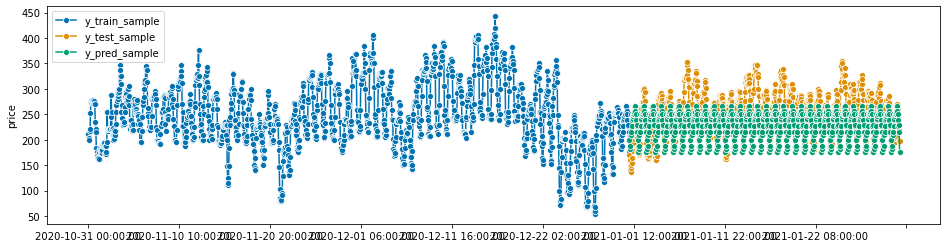

In [37]:
naive_forecaster = NaiveForecaster(strategy='last', sp=24)
naive_forecaster.fit(y_train_sample)
fh_index = y_test_sample.index

fh = ForecastingHorizon(fh_index, is_relative=False)
y_pred_sample = naive_forecaster.predict(fh)
plot_series(y_train_sample, y_test_sample, y_pred_sample, 
            labels=['y_train_sample', 'y_test_sample', 'y_pred_sample'])

rmse_test = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
rmse_ext = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_test_sample))
print(f'Naive forecaster RMSE: {rmse_test}. External predictions RMSE: {rmse_ext}')

In [38]:
naive_forecasters = {
    'sp1_last': NaiveForecaster(strategy='last', sp=1),
    'sp1_mean_1': NaiveForecaster(strategy='mean', sp=1, window_length=24),
    'sp1_mean_2': NaiveForecaster(strategy='mean', sp=1, window_length=48),
    'sp1_mean_3': NaiveForecaster(strategy='mean', sp=1, window_length=72),
    'sp1_mean_4': NaiveForecaster(strategy='mean', sp=1, window_length=96),
    'sp1_mean_5': NaiveForecaster(strategy='mean', sp=1, window_length=120),
    'sp1_mean_6': NaiveForecaster(strategy='mean', sp=1, window_length=144),
    'sp1_mean_7': NaiveForecaster(strategy='mean', sp=1, window_length=168),
    'sp1_mean_all': NaiveForecaster(strategy='mean', sp=1, window_length=None),
    'sp24_last': NaiveForecaster(strategy='last', sp=24),
    'sp24_mean_1': NaiveForecaster(strategy='mean', sp=24, window_length=24),
    'sp24_mean_2': NaiveForecaster(strategy='mean', sp=24, window_length=48),
    'sp24_mean_3': NaiveForecaster(strategy='mean', sp=24, window_length=72),
    'sp24_mean_4': NaiveForecaster(strategy='mean', sp=24, window_length=96),
    'sp24_mean_5': NaiveForecaster(strategy='mean', sp=24, window_length=120),
    'sp24_mean_6': NaiveForecaster(strategy='mean', sp=24, window_length=144),
    'sp24_mean_7': NaiveForecaster(strategy='mean', sp=24, window_length=168),
    'sp24_mean_all': NaiveForecaster(strategy='mean', sp=24, window_length=None),
}

In [39]:
fh_index = y_test_sample.index
fh = ForecastingHorizon(fh_index, is_relative=False)
rmse_metrics = dict()
for naive_forecaster_name, naive_forecaster in naive_forecasters.items():
    forecaster = copy.deepcopy(naive_forecaster)
    forecaster.fit(y_train_sample)
    y_pred_sample = forecaster.predict(fh)
    rmse = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
    rmse_metrics[naive_forecaster_name] = rmse

In [40]:
rmse_metrics

{'sp1_last': 88.68550698882873,
 'sp1_mean_1': 50.62915178387905,
 'sp1_mean_2': 52.017785057651075,
 'sp1_mean_3': 54.78151988429431,
 'sp1_mean_4': 58.19422757263181,
 'sp1_mean_5': 69.371234931098,
 'sp1_mean_6': 73.04884581473956,
 'sp1_mean_7': 74.58582529732865,
 'sp1_mean_all': 45.26141107061557,
 'sp24_last': 39.88389201087933,
 'sp24_mean_1': 39.88389201087933,
 'sp24_mean_2': 40.837606529477846,
 'sp24_mean_3': 44.03160387833455,
 'sp24_mean_4': 49.6825918827663,
 'sp24_mean_5': 62.033832726303906,
 'sp24_mean_6': 65.84046718533439,
 'sp24_mean_7': 67.73135644737155,
 'sp24_mean_all': 30.864759327466633}

Naive forecaster RMSE: 30.864759327466633. External predictions RMSE: 25.32533193094695


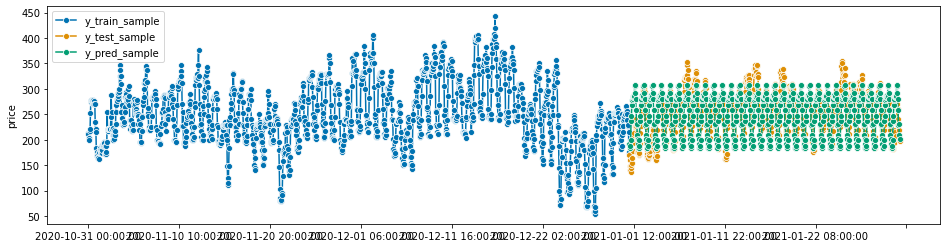

In [41]:
best_forecaster_name = max(rmse_metrics, key=rmse_metrics.get)
best_forecaster = naive_forecasters.get(best_forecaster_name)
best_forecaster.fit(y_train_sample)
y_pred_sample = forecaster.predict(fh)
rmse_test = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
rmse_ext = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_test_sample))
plot_series(y_train_sample, y_test_sample, y_pred_sample,
            labels=['y_train_sample', 'y_test_sample', 'y_pred_sample'])
print(f'Naive forecaster RMSE: {rmse_test}. External predictions RMSE: {rmse_ext}')

Naive forecaster RMSE: 30.331601387499976. External predictions RMSE: 25.32533193094695


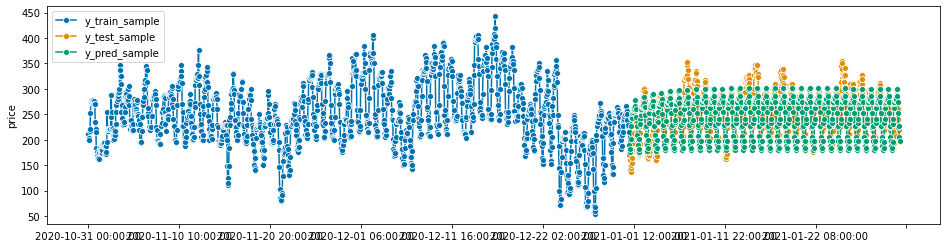

In [42]:
fh_index = y_test_sample.index
fh = ForecastingHorizon(fh_index, is_relative=False)

forecaster = ARIMA(order=(0, 0, 0), seasonal_order=(1, 1, 3, 24), suppress_warnings=True)
forecaster.fit(y_train_sample)
y_pred_sample = forecaster.predict(fh)
rmse_test = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
rmse_ext = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_test_sample))
plot_series(y_train_sample, y_test_sample, y_pred_sample,
            labels=['y_train_sample', 'y_test_sample', 'y_pred_sample'])
print(f'Naive forecaster RMSE: {rmse_test}. External predictions RMSE: {rmse_ext}')

In [43]:
forecaster.get_fitted_params()

{'intercept': -0.017334859866387088,
 'ar.S.L24': 0.7250198141383678,
 'ma.S.L24': -1.195117010327285,
 'ma.S.L48': 0.18911215638180956,
 'ma.S.L72': 0.006593350819764239,
 'sigma2': 1579.1153498708993}

In [57]:
def evaluate(forecaster, y,  y_benchmark, strategy="refit", initial_window=24, step=24):
    fh = [hour for hour in range(1, step+1)]
    idx_max = int((len(y) - step) / step) + 1
    predictions, benchmarks, observed = list(), list(), list()
    rmse, rmse_benchmark, prediction_dates = list(), list(), list()
    for idx in range(idx_max):
        y_train = y.iloc[:initial_window+idx*step].copy()
        y_test = y.iloc[initial_window+idx*step:initial_window+(idx+1)*step].copy()
        y_bench = y_benchmark.iloc[initial_window+idx*step:initial_window+(idx+1)*step].copy()
        if len(y_test) == step:
            prediction_date = np.unique(y_test.index.date)[0]
            forecaster.fit(y_train)
            y_pred = forecaster.predict(fh)
            predictions.append(y_pred)
            benchmarks.append(y_bench)
            observed.append(y_test)
            rmse.append(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
            rmse_benchmark.append(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_bench)))
            prediction_dates.append(prediction_date)
    predictions = pd.concat(predictions, axis=0)
    benchmarks = pd.concat(benchmarks, axis=0)
    observed = pd.concat(observed, axis=0)
    results = pd.DataFrame({'predictions': predictions, 'benchmarks': benchmarks, 'observed': observed})
    rmse = pd.DataFrame({'date': prediction_dates, 'rmse': rmse, 'rmse_benchmark': rmse_benchmark})
    return results, rmse

sp = 24
forecaster = NaiveForecaster(strategy='mean', sp=sp, window_length=None)
results, rmse = evaluate(
    forecaster=forecaster, 
    y=y_train_sample, 
    y_benchmark=y_pred_train_sample,
    initial_window=sp,
    step=24
)

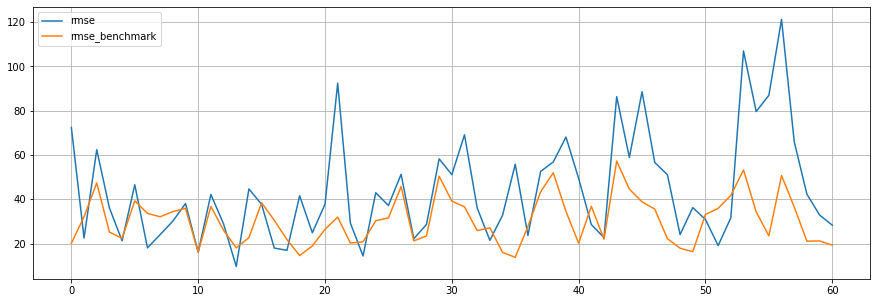

In [58]:
rmse.plot()
plt.grid()

In [62]:
rmse.mean()

rmse              43.954459
rmse_benchmark    30.583283
dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='predictions'>)

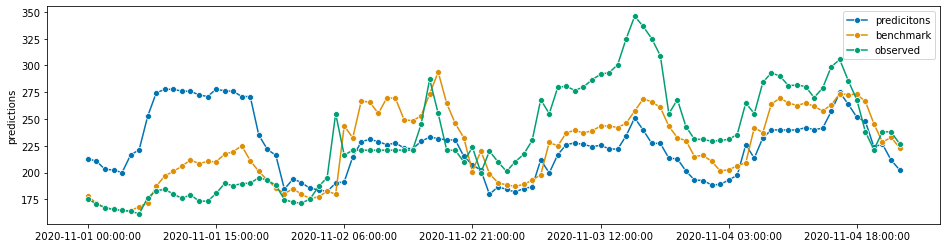

In [59]:
plot_series(results['predictions'].iloc[:96], results['benchmarks'].iloc[:96],results['observed'].iloc[:96],
            labels=['predicitons', 'benchmark', 'observed'])


In [60]:
results

,predictions,benchmarks,observed
2020-11-01 00:00:00,212.910000,177.677368,175.06
2020-11-01 01:00:00,210.600000,171.529842,170.76
2020-11-01 02:00:00,203.000000,166.768976,167.23
2020-11-01 03:00:00,202.410000,165.798314,165.60
2020-11-01 04:00:00,200.000000,164.457876,164.58
...,...,...,...
2020-12-31 19:00:00,257.852459,225.613956,239.50
2020-12-31 20:00:00,228.603607,220.507092,227.00
2020-12-31 21:00:00,231.355082,207.238365,229.75
2020-12-31 22:00:00,209.113443,206.645604,215.42


## Benchmark set of forecasters

In [48]:
def naive_forecasters_factory():
    naive_forecasters = {
    'sp1_last': NaiveForecaster(strategy='last', sp=1),
    'sp1_mean_1': NaiveForecaster(strategy='mean', sp=1, window_length=24),
    'sp1_mean_2': NaiveForecaster(strategy='mean', sp=1, window_length=48),
    'sp1_mean_3': NaiveForecaster(strategy='mean', sp=1, window_length=72),
    'sp1_mean_4': NaiveForecaster(strategy='mean', sp=1, window_length=96),
    'sp1_mean_5': NaiveForecaster(strategy='mean', sp=1, window_length=120),
    'sp1_mean_6': NaiveForecaster(strategy='mean', sp=1, window_length=144),
    'sp1_mean_7': NaiveForecaster(strategy='mean', sp=1, window_length=168),
    'sp1_mean_all': NaiveForecaster(strategy='mean', sp=1, window_length=None),
    'sp24_last': NaiveForecaster(strategy='last', sp=24),
    'sp24_mean_1': NaiveForecaster(strategy='mean', sp=24, window_length=24),
    'sp24_mean_2': NaiveForecaster(strategy='mean', sp=24, window_length=48),
    'sp24_mean_3': NaiveForecaster(strategy='mean', sp=24, window_length=72),
    'sp24_mean_4': NaiveForecaster(strategy='mean', sp=24, window_length=96),
    'sp24_mean_5': NaiveForecaster(strategy='mean', sp=24, window_length=120),
    'sp24_mean_6': NaiveForecaster(strategy='mean', sp=24, window_length=144),
    'sp24_mean_7': NaiveForecaster(strategy='mean', sp=24, window_length=168),
    'sp24_mean_all': NaiveForecaster(strategy='mean', sp=24, window_length=None),
    }
    return naive_forecasters

def arima_forecasters_factory():
    return dict()

def benchmark_forecasters_factory():
    benchmark_forecasters = dict()
    benchmark_forecasters.update(naive_forecasters_factory())
    benchmark_forecasters.update(arima_forecasters_factory())
    return benchmark_forecasters

## Train/test full sample

In [49]:
naive_forecasters = {
    'sp1_last': NaiveForecaster(strategy='last', sp=1),
    'sp1_mean_1': NaiveForecaster(strategy='mean', sp=1, window_length=24),
    'sp1_mean_2': NaiveForecaster(strategy='mean', sp=1, window_length=48),
    'sp1_mean_3': NaiveForecaster(strategy='mean', sp=1, window_length=72),
    'sp1_mean_4': NaiveForecaster(strategy='mean', sp=1, window_length=96),
    'sp1_mean_5': NaiveForecaster(strategy='mean', sp=1, window_length=120),
    'sp1_mean_6': NaiveForecaster(strategy='mean', sp=1, window_length=144),
    'sp1_mean_7': NaiveForecaster(strategy='mean', sp=1, window_length=168),
    'sp1_mean_all': NaiveForecaster(strategy='mean', sp=1, window_length=None),
    'sp24_last': NaiveForecaster(strategy='last', sp=24),
    'sp24_mean_1': NaiveForecaster(strategy='mean', sp=24, window_length=24),
    'sp24_mean_2': NaiveForecaster(strategy='mean', sp=24, window_length=48),
    'sp24_mean_3': NaiveForecaster(strategy='mean', sp=24, window_length=72),
    'sp24_mean_4': NaiveForecaster(strategy='mean', sp=24, window_length=96),
    'sp24_mean_5': NaiveForecaster(strategy='mean', sp=24, window_length=120),
    'sp24_mean_6': NaiveForecaster(strategy='mean', sp=24, window_length=144),
    'sp24_mean_7': NaiveForecaster(strategy='mean', sp=24, window_length=168),
    'sp24_mean_all': NaiveForecaster(strategy='mean', sp=24, window_length=None),
}

In [50]:
fh_index = y_test.index
fh = ForecastingHorizon(fh_index, is_relative=False)
rmse_metrics = dict()
for naive_forecaster_name, naive_forecaster in naive_forecasters.items():
    forecaster = copy.deepcopy(naive_forecaster)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
    rmse_metrics[naive_forecaster_name] = rmse

In [51]:
rmse_metrics

{'sp1_last': 98.21779942582012,
 'sp1_mean_1': 58.13418667059755,
 'sp1_mean_2': 59.791323064975906,
 'sp1_mean_3': 62.96040471618108,
 'sp1_mean_4': 66.72654127264163,
 'sp1_mean_5': 78.5268038009509,
 'sp1_mean_6': 82.31754234577284,
 'sp1_mean_7': 83.89391930787987,
 'sp1_mean_all': 71.49030224896335,
 'sp24_last': 50.65415925302483,
 'sp24_mean_1': 50.65415925302483,
 'sp24_mean_2': 52.061364717311264,
 'sp24_mean_3': 55.62363922259745,
 'sp24_mean_4': 61.44247035633353,
 'sp24_mean_5': 74.03458564484153,
 'sp24_mean_6': 77.78061481591779,
 'sp24_mean_7': 79.74104178475055,
 'sp24_mean_all': 64.61722656126032}

Naive forecaster RMSE: 64.61722656126032. External predictions RMSE: 24.736368591793646


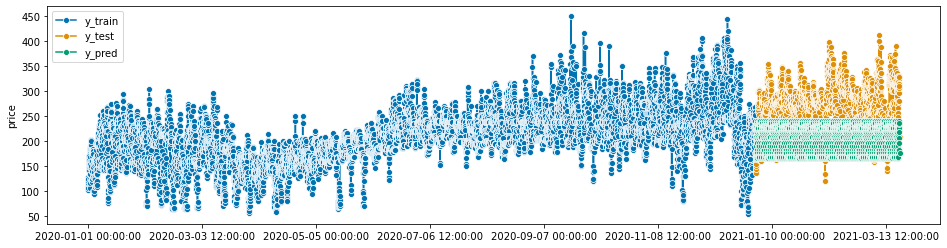

In [52]:
best_forecaster_name = max(rmse_metrics, key=rmse_metrics.get)
best_forecaster = naive_forecasters.get(best_forecaster_name)
best_forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
rmse_test = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
rmse_ext = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_ext_test))
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
print(f'Naive forecaster RMSE: {rmse_test}. External predictions RMSE: {rmse_ext}')